# Hampton Roads Energy Consumption Analysis for Energy Efficiency and Sustainability


# Project Details

## Group Members

> Maya Bollino
<br> Email: mboll001@odu.edu
<br> Portfolio: https://mayaboll.github.io/

> Alaina McKnight
<br> Email: amckn005@odu.edu
<br> Portfolio: https://amckn005.github.io/


## Abstract


This project explores the relationships between demographics, socioeconomic factors, population density, and energy consumption within the Hampton Roads area. The objective is to analyze the influence of these variables on energy consumption patterns, identify significant correlations, and develop visualizations to enhance sustainable energy planning and resource allocation. The findings from this study will contribute to a deeper understanding of energy consumption dynamics and inform decisions aimed at promoting energy efficiency and sustainability in the Hampton Roads region.


## Project Plan

Dates <img width=70/> | Project Plan <img width=200/>
------------------|-----------------
8/26 - 9/20       | Collect Raw Data
9/20 - 10/4       | Cleaning and Pre-processing Dataset
10/5 - 10/16      | Data Analysis
**10/10**         | **Progress Check I**
10/17 - 11/13     | Data Visualization and Modeling
**11/13**         | **Progress Check II**
11/14 - 12/3      | Draft Report
12/4 - 12/10      | Youtube Video/Demo
**12/11**         | **Submit Project**





## Roles and Responsibilities


> **Team Member 1:**
<br>Data Collection and Cleaning: Gather and organize raw data from various sources and ensure its accuracy and completeness.
<br>Data Preprocessing: Conduct data cleaning, imputation, and feature engineering to prepare the data for analysis.
<br>Data Exploration: Perform initial exploratory data analysis to identify patterns, outliers, and correlations.

> **Team Member 2:**
<br>Data Analysis: Conduct in-depth analysis using statistical methods, machine learning, or other relevant techniques to derive meaningful insights.
<br>Model Development: Develop predictive models, algorithms, or statistical approaches to address project objectives.
<br>Model Evaluation: Assess the performance of models and make recommendations for improvement.

> **Collaborative Responsibilities:**
<br>Data Modeling: Collaborate with one another to select appropriate models, tune parameters, and assess model performance.
<br>Documentation: Maintain clear and organized documentation of modeling approaches, results, and interpretations.
<br>Reporting and Visualization: Assist in creating visualizations and summarizing findings for presentation.




## Data Information

Primary dataset:
> City and County Energy Profiles
<br> Source: Data.gov - National Renewable Energy Laboratory
<br> Link: [https://catalog.data.gov/dataset/city-and-county-energy-profiles](https://catalog.data.gov/dataset/city-and-county-energy-profiles-60fbd)

Secondary datasets:
> Virginia Demographics and Housing Estimates of 2016
<br> Source: US Census Bureau
<br> Link: [https://data.census.gov/table?t=Populations+and+People](https://data.census.gov/table?t=Populations+and+People&g=040XX00US51$0500000&y=2016&tid=ACSDP1Y2016.DP05&moe=false)

> Virginia Income in the Past 12 Months (in 2016 Inflation-Adjusted Dollars)
<br> Source: US Census Bureau
<br> Link: [https://data.census.gov/table?q=virginia+income](https://data.census.gov/table?q=virginia+income&g=040XX00US51$0500000&y=2016&tid=ACSST1Y2016.S1901&moe=false)

> Virginia Financial Characteristics
<br> Source: US Census Bureau
<br> Link: [https://data.census.gov/table?q=virginia+income](https://data.census.gov/table?q=virginia+income&g=040XX00US51$0500000&y=2016&tid=ACSST1Y2016.S2503&moe=false)

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

Saving county_energyprofile2016.csv to county_energyprofile2016 (1).csv
Saving demographicsVA2016.csv to demographicsVA2016 (1).csv
Saving financialVA2016.csv to financialVA2016 (1).csv
Saving incomeVA2016.csv to incomeVA2016 (1).csv


#### Primary Dataset

In [ ]:

import pandas as pd
import io
from pandas import Series, DataFrame

# read county energy data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

pd.set_option('display.max_columns', None)
county_energy = pd.read_csv(io.BytesIO(uploaded['county_energyprofile2016.csv']))

# clean energy data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

rename_column = county_energy.columns[county_energy.loc[0] == 'On-road Transportation'] # rename mislabeled values
county_energy.loc[0, rename_column] = 'On Road Transportation'

categories = list(county_energy.loc[0].unique()[1:]) # split into categories, minus first 14 columns (nan)

CE = {} # dictionary to store category dataframes

# loop through categories to create sub-dataframes
for category in categories:
  first14 = county_energy.iloc[:, :14]
  category_subset = county_energy.loc[:, county_energy.loc[0] == category]
  CE_category = pd.merge(first14, category_subset, left_index = True, right_index = True)
  CE[category] = CE_category

CE_res = CE['Residential']
CE_trans = CE['On Road Transportation']
CE_em = CE['Emissions factors']
CE_com = CE['Commercial']
CE_ind = CE['Industry']

# define reset dataframe headers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def reset_headers(df, category):

  # loop through columns to create header labels
  columns = df.loc[:, df.loc[0] == category].columns
  for column in columns:
    if not pd.isna(df.loc[1, column]): # if value in row 1 is not nan
      df.loc[3, column] = df.loc[1, column] + ' ' + df.loc[3, column] # combine value labels from row 1 to row 3

  # set header
  df = df.drop([0,1,2]).reset_index(drop = True)
  df.columns = df.iloc[0]
  df = df.drop(0)

  return df

# reset headers for each category ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

CE_res = reset_headers(CE_res, 'Residential')
CE_trans = reset_headers(CE_trans, 'On Road Transportation')
CE_em = reset_headers(CE_em, 'Emissions factors')

# clean Commmercial category (rename label by local and state)
local_columns = CE_com.columns[CE_com.columns.str.contains('Local')]
state_columns = CE_com.columns[CE_com.columns.str.contains('State')]
CE_com.loc[1, local_columns] = 'Local ' + CE_com.loc[1, local_columns]
CE_com.loc[1, state_columns] = 'State ' + CE_com.loc[1, state_columns]
CE_com = reset_headers(CE_com, 'Commercial')

# clean Industry category (rename labels by NAICS codes)
naics_columns = CE_ind.columns[CE_ind.columns.str.contains('NAICS')]
#CE_ind.loc[2, naics_columns] = 'NAICS_' + CE_ind.loc[2, naics_columns]
#CE_ind.loc[3, naics_columns] = CE_ind.loc[2, naics_columns] + ' ' + CE_ind.loc[3, naics_columns]
CE_ind = CE_ind.drop(columns = naics_columns)
CE_ind = reset_headers(CE_ind, 'Industry')

# define only Hampton Roads VA data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def hamptonroads(df):

  HamptonRoads = ['Norfolk','Virginia Beach','Newport News','Chesapeake','Portsmouth','Williamsburg',
                'Gloucester County','Suffolk','Surry County','Poquoson','York County','James City County',
                'Isle of Wight County','Mathews County','Gates County','Currituck County','Franklin']

  VA = df[df['state_abbr'] == 'VA'] # select only VA states

  VA_counties = pd.DataFrame(columns = VA.columns) # empty dataframe to store all VA counties

  # only rows with county in hampton roads
  for county in HamptonRoads:
    county_name = VA[VA['county_name'].str.contains(county)]
    VA_counties = pd.concat([VA_counties, county_name]).reset_index(drop = True)

  return VA_counties

# final dataframe for each category ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

HRCE_res = hamptonroads(CE_res)
HRCE_trans = hamptonroads(CE_trans)
HRCE_em = hamptonroads(CE_em)
HRCE_com = hamptonroads(CE_com)
HRCE_ind = hamptonroads(CE_ind)

# convert numeric columns
df_list = [HRCE_res, HRCE_trans, HRCE_em, HRCE_com, HRCE_ind]
for df in df_list:
  for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='ignore')


KeyError: ignored

In [ ]:
# display dataframe
HRCE_ind

,state_id,state_abbr,county_state_name,county_id,county_name,latitude,longitude,consolidated_city-county,population,population_cohort,employment,employment_cohort,doe_climate_zone,cohort,Electricity consumption (MWh),Electricity expenditures ('000 $),Electricity consumption (MWh/capita),Electricity expenditures ('000 $/capita),Natural Gas consumption (TcF),Natural Gas expenditures ('000 $),Natural Gas consumption (TcF/capita),Natural Gas expenditures ('000 $/capita),establishments,Electricity GHG emissions mtons CO2e,Natural Gas GHG emissions mtons CO2e
0,51,VA,"Norfolk city, VA",51710,Norfolk city,36.923015,-76.244641,NaN,245724,11,201951,11,4,41111,5.173142e+04,3391.503661,0.210527,0.013802,4.135834e+05,1828.038520,1.683122,0.007439,NaN,19009.691260,22739.142170
1,51,VA,"Virginia Beach city, VA",51810,Virginia Beach city,36.779985,-76.025209,NaN,449733,13,315930,12,4,41312,1.156938e+05,7584.866942,0.257250,0.016865,2.334177e+05,1031.706187,0.519014,0.002294,NaN,42513.879770,12833.489780
2,51,VA,"Newport News city, VA",51700,Newport News city,37.076166,-76.521968,NaN,181606,10,180864,10,4,41010,5.842037e+04,3830.030117,0.321687,0.021090,6.324578e+05,2795.463428,3.482582,0.015393,NaN,21467.672550,34773.031100
3,51,VA,"Chesapeake city, VA",51550,Chesapeake city,36.679376,-76.301788,NaN,233194,11,179758,10,4,41110,6.550276e+04,4294.350112,0.280894,0.018415,5.920214e+05,2616.734573,2.538751,0.011221,NaN,24070.229010,32549.806160
4,51,VA,"Portsmouth city, VA",51740,Portsmouth city,36.859623,-76.356307,NaN,96071,9,54039,7,4,40907,1.740865e+04,1141.308063,0.181206,0.011880,6.846810e+04,302.629012,0.712682,0.003150,NaN,6397.137108,3764.430596
5,51,VA,"Williamsburg city, VA",51830,Williamsburg city,37.269481,-76.708193,NaN,14988,4,17579,5,4,40405,1.805437e+03,118.364136,0.120459,0.007897,3.295237e+03,14.564950,0.219858,0.000972,NaN,663.441916,181.174770
6,51,VA,"Gloucester County, VA",51073,Gloucester County,37.403541,-76.523505,NaN,37021,6,14496,4,4,40604,3.990010e+03,261.584404,0.107777,0.007066,2.430837e+03,10.744300,0.065661,0.000290,NaN,2264.959848,133.649350
7,51,VA,"Suffolk city, VA",51800,Suffolk city,36.697157,-76.634781,NaN,87061,9,43612,7,4,40907,1.314369e+04,861.698201,0.150971,0.009898,9.724984e+03,42.984429,0.111703,0.000494,NaN,4829.898004,534.687333
8,51,VA,"Surry County, VA",51181,Surry County,37.119761,-76.880172,NaN,6731,2,1700,1,4,40201,3.545278e+03,232.427832,0.526709,0.034531,3.499733e+03,15.468821,0.519943,0.002298,NaN,1302.779464,192.418106
9,51,VA,"Poquoson city, VA",51735,Poquoson city,37.128360,-76.303534,NaN,12068,4,2457,1,4,40401,2.416053e+02,15.839601,0.020020,0.001313,8.441243e+02,3.731029,0.069947,0.000309,NaN,88.782427,46.410624


#### Secondary Datasets

In [ ]:
# read demographics data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

demographics = pd.read_csv('/content/demographicsVA2016.csv')
demographics = demographics.T

# select only Hampton Roads VA data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

HamptonRoads = ['Norfolk city','Virginia Beach city','Newport News city','Chesapeake city','Portsmouth city',
                'Williamsburg','Gloucester County','Suffolk city','Surry County','Poquoson','York County',
                'James City County','Isle of Wight County','Mathews County','Gates County','Currituck County',
                'Franklin','Hampton city']

# reorganize index columns
demo = demographics.reset_index(drop=False)
demo.columns = demo.iloc[0]
demo = demo.drop(0)
demo = demo.rename(columns = {'Label (Grouping)':'Virginia County'})

# only Hampton Roads counties
demo = demo[demo['Virginia County'].str.contains('Estimate')] # remove percent rows (not needed?)
demo['Virginia County'] = demo['Virginia County'].str.split(',').str[0] # remove county label after comma (,)
demoHR = demo[demo['Virginia County'].isin(HamptonRoads)].reset_index(drop = True) # select only Hampton Roads

# break into sub-dataframes ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

demoHR_Age = demoHR.iloc[:, :29]
demoHR_Age = demoHR_Age.drop(demoHR_Age.columns[1], axis=1) # SEX AND AGE
demoHR_Race = demoHR.iloc[:, [0] + list(range(30,68))] # RACE
demoHR_HLRace = demoHR.iloc[:, [0] + list(range(69,86))] # HISPANIC OR LATINO AND RACE
demoHR_VAge = demoHR.iloc[:, [0] + list(range(87,90))] # CITIZEN, VOTING AGE POPULATION


In [ ]:
# display dataframe
demoHR_Age

,Virginia County,Total population,Male,Female,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),18 years and over,21 years and over,62 years and over,65 years and over,18 years and over,Male,Female,65 years and over,Male,Female
0,James City County,"74,404","34,824","39,580","2,418","4,170","5,959","5,755","2,479","6,985","7,841","9,743","4,600","5,596","10,731","6,103","2,024",47.2,"59,129","55,115","22,720","18,858","59,129","27,573","31,556","18,858","8,422","10,436"
1,York County,"67,976","32,325","35,651","3,690","4,441","5,494","4,999","4,365","6,883","9,442","9,409","4,307","4,662","6,105","3,024","1,155",39.5,"51,390","48,393","12,872","10,284","51,390","24,435","26,955","10,284","4,514","5,770"
2,Chesapeake city,"237,940","116,137","121,803","15,605","16,911","14,302","15,508","14,932","35,676","30,620","34,061","16,471","14,137","18,220","8,063","3,434",36.9,"180,367","172,457","38,230","29,717","180,367","86,774","93,593","29,717","12,596","17,121"
3,Hampton city,"135,410","64,156","71,254","8,006","7,294","8,730","9,000","11,387","21,867","14,623","17,048","10,285","7,875","11,139","5,902","2,254",36.2,"106,949","99,528","24,583","19,295","106,949","50,203","56,746","19,295","7,945","11,350"
4,Newport News city,"181,825","88,786","93,039","13,046","11,842","10,689","11,787","18,252","29,759","20,136","22,876","12,069","9,152","13,148","6,440","2,629",33.4,"139,775","131,241","27,380","22,217","139,775","67,143","72,632","22,217","8,841","13,376"
5,Norfolk city,"245,115","127,741","117,374","16,583","13,839","12,440","16,386","34,096","47,028","27,187","25,459","14,890","11,924","14,719","7,028","3,536",30.6,"195,536","178,413","31,642","25,283","195,536","102,527","93,009","25,283","10,588","14,695"
6,Portsmouth city,"95,252","45,634","49,618","6,962","6,748","5,366","6,091","7,716","14,774","11,010","11,115","6,719","5,369","7,547","3,866","1,969",35.0,"72,747","67,731","16,435","13,382","72,747","34,462","38,285","13,382","5,435","7,947"
7,Suffolk city,"89,273","43,617","45,656","5,754","5,465","7,090","5,914","5,547","10,924","11,780","13,055","6,219","5,305","7,514","3,448","1,258",38.2,"67,174","64,182","14,956","12,220","67,174","32,144","35,030","12,220","5,498","6,722"
8,Virginia Beach city,"452,602","222,398","230,204","29,127","24,995","30,844","27,460","33,588","75,365","58,150","58,740","29,152","25,591","35,486","17,471","6,633",35.8,"350,825","333,512","73,678","59,590","350,825","170,662","180,163","59,590","25,535","34,055"


In [ ]:
# read income data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

income = pd.read_csv('/content/incomeVA2016.csv')
income = income.T

# select only Hampton Roads VA data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

HamptonRoads = ['Norfolk city','Virginia Beach city','Newport News city','Chesapeake city','Portsmouth city',
                'Williamsburg','Gloucester County','Suffolk city','Surry County','Poquoson','York County',
                'James City County','Isle of Wight County','Mathews County','Gates County','Currituck County',
                'Franklin','Hampton city']

# reorganize index columns
inc = income.reset_index(drop=False)
inc.columns = inc.iloc[0]
inc = inc.drop(0)
inc = inc.rename(columns = {'Label (Grouping)':'Virginia County'})

# select Hampton Roads counties
# keep first 4 rows, then select only HR counties from the rest
first4 = inc[:4]
all_counties = inc[4:]
HR_counties = pd.DataFrame() # empty dataframe to store all HR counties
for county in HamptonRoads:
  county_name = all_counties[all_counties['Virginia County'].str.contains(county)]
  HR_counties = pd.concat([HR_counties, county_name])
# combine first 4 and HR counties
inc = pd.concat([first4, HR_counties]).reset_index(drop=True)

# create sub-dataframes ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Households, Families, Married-couple families, Nonfamily households
incHouse = inc[inc['Virginia County'].str.contains('Households')].reset_index(drop=True)
incFamily = inc[inc['Virginia County'].str.contains('Families')].reset_index(drop=True)
incCouple = inc[inc['Virginia County'].str.contains('Married-couple families')].reset_index(drop=True)
incNonfam = inc[inc['Virginia County'].str.contains('Nonfamily households')].reset_index(drop=True)

# clean up county labels
def clean_label(df):
  df['Virginia County'] = df['Virginia County'].str.split('!').str[0]
clean_label(incHouse)
clean_label(incFamily)
clean_label(incCouple)
clean_label(incNonfam)


In [ ]:
inc

In [ ]:
# display dataframe
incHouse

,Virginia County,Total,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),PERCENT ALLOCATED,Household income in the past 12 months,Family income in the past 12 months,Nonfamily income in the past 12 months
0,Virginia,"3,120,692",5.6%,3.9%,7.8%,8.0%,11.8%,17.0%,12.8%,16.2%,7.6%,9.3%,"68,114","93,939",NaN,34.6%,(X),(X)
1,"Norfolk city, Virginia","87,910",9.5%,6.1%,11.6%,11.7%,14.7%,18.9%,10.1%,9.8%,4.4%,3.1%,"46,467","64,343",NaN,42.6%,(X),(X)
2,"Virginia Beach city, Virginia","168,061",3.7%,2.6%,6.7%,6.4%,12.7%,20.6%,14.8%,19.1%,7.5%,5.9%,"71,117","90,576",NaN,34.6%,(X),(X)
3,"Newport News city, Virginia","67,628",7.0%,4.2%,12.8%,10.4%,15.1%,20.3%,11.4%,12.1%,3.6%,3.2%,"50,524","64,926",NaN,34.6%,(X),(X)
4,"Chesapeake city, Virginia","83,364",3.8%,3.4%,5.5%,6.9%,12.2%,19.8%,15.2%,19.7%,7.1%,6.5%,"72,928","90,320",NaN,42.9%,(X),(X)
5,"Portsmouth city, Virginia","36,615",7.8%,6.1%,10.9%,11.2%,14.9%,19.9%,11.7%,11.3%,4.3%,1.8%,"48,516","60,637",NaN,51.6%,(X),(X)
6,"Suffolk city, Virginia","33,377",3.5%,2.6%,10.0%,9.1%,12.3%,17.9%,15.7%,17.8%,6.4%,4.8%,"66,669","85,140",NaN,32.8%,(X),(X)
7,"York County, Virginia","23,797",1.7%,1.5%,5.3%,4.1%,12.4%,15.2%,16.3%,25.3%,7.2%,11.0%,"89,418","105,338",NaN,26.4%,(X),(X)
8,"James City County, Virginia","28,480",4.6%,3.7%,5.2%,6.5%,10.0%,14.3%,14.0%,22.4%,9.2%,10.2%,"83,455","109,488",NaN,29.1%,(X),(X)
9,"Hampton city, Virginia","54,181",7.8%,4.5%,8.2%,10.5%,18.2%,20.3%,12.7%,11.9%,3.6%,2.3%,"50,435","65,991",NaN,34.3%,(X),(X)


In [ ]:
# read financial data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

financial = pd.read_csv('/content/financialVA2016.csv')
financial = financial.T

# select only Hampton Roads VA data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

HamptonRoads = ['Norfolk city','Virginia Beach city','Newport News city','Chesapeake city','Portsmouth city',
                'Williamsburg','Gloucester County','Suffolk city','Surry County','Poquoson','York County',
                'James City County','Isle of Wight County','Mathews County','Gates County','Currituck County',
                'Franklin','Hampton city']

# reorganize index columns
fin = financial.reset_index(drop=False)
fin.columns = fin.iloc[0]
fin = fin.drop(0)
fin = fin.rename(columns = {'Label (Grouping)':'Virginia County'})

# select Hampton Roads counties
# keep first 3 rows, then select only HR counties from the rest
first3 = fin[:3]
all_counties = fin[3:]
HR_counties = pd.DataFrame() # empty dataframe to store all HR counties
for county in HamptonRoads:
  county_name = all_counties[all_counties['Virginia County'].str.contains(county)]
  HR_counties = pd.concat([HR_counties, county_name])
# combine first 3 and HR counties
fin = pd.concat([first3, HR_counties]).reset_index(drop=True)

# create sub-dataframes ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Occupied housing units, Owner-occupied housing units, Renter-occupied housing units
finOccupied = fin[fin['Virginia County'].str.contains('Occupied housing units')].reset_index(drop=True)
finOwnerOcc = fin[fin['Virginia County'].str.contains('Owner-occupied housing units')].reset_index(drop=True)
finRenterOcc = fin[fin['Virginia County'].str.contains('Renter-occupied housing units')].reset_index(drop=True)

# clean up county labels
clean_label(finOccupied)
clean_label(finOwnerOcc)
clean_label(finRenterOcc)


In [ ]:
# display dataframe
finOccupied

,Virginia County,Occupied housing units,HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS),"Less than $5,000","$5,000 to $9,999","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 or more",Median household income (dollars),MONTHLY HOUSING COSTS,Less than $300,$300 to $499,$500 to $799,$800 to $999,"$1,000 to $1,499","$1,500 to $1,999","$2,000 to $2,499","$2,500 to $2,999","$3,000 or more",No cash rent,Median (dollars),MONTHLY HOUSING COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS,"Less than $20,000",Less than 20 percent,20 to 29 percent,30 percent or more,"$20,000 to $34,999",Less than 20 percent,20 to 29 percent,30 percent or more,"$35,000 to $49,999",Less than 20 percent,20 to 29 percent,30 percent or more,"$50,000 to $74,999",Less than 20 percent,20 to 29 percent,30 percent or more,"$75,000 or more",Less than 20 percent,20 to 29 percent,30 percent or more,Zero or negative income,No cash rent
0,Virginia,"3,120,692",NaN,2.8%,2.8%,3.9%,3.8%,3.9%,8.0%,11.8%,17.0%,12.8%,16.2%,16.9%,"68,114",NaN,6.1%,9.1%,13.6%,10.3%,22.1%,15.9%,9.2%,5.0%,6.9%,1.9%,"1,215",NaN,11.6%,0.9%,1.3%,9.4%,11.6%,2.4%,1.8%,7.5%,11.5%,3.4%,3.0%,5.1%,16.7%,6.7%,5.3%,4.7%,45.7%,31.3%,11.1%,3.2%,1.0%,1.9%
1,"Norfolk city, Virginia","87,910",NaN,4.9%,4.6%,6.1%,6.2%,5.4%,11.7%,14.7%,18.9%,10.1%,9.8%,7.6%,"46,467",NaN,5.0%,5.5%,14.7%,18.3%,31.7%,13.8%,5.2%,1.9%,2.6%,1.3%,"1,077",NaN,19.8%,1.2%,1.6%,17.0%,16.8%,1.8%,1.9%,13.0%,14.4%,1.7%,6.5%,6.2%,18.7%,6.9%,7.4%,4.4%,27.3%,19.1%,6.7%,1.4%,1.7%,1.3%
2,"Virginia Beach city, Virginia","168,061",NaN,2.1%,1.7%,2.6%,2.6%,4.1%,6.4%,12.7%,20.6%,14.8%,19.1%,13.5%,"71,117",NaN,2.0%,4.7%,9.1%,9.6%,30.7%,23.6%,10.9%,4.6%,4.2%,0.7%,"1,386",NaN,7.8%,0.2%,0.7%,6.9%,10.4%,1.0%,1.0%,8.4%,12.6%,1.8%,2.3%,8.5%,20.4%,4.3%,8.0%,8.1%,47.2%,31.0%,12.7%,3.5%,0.9%,0.7%
3,"Newport News city, Virginia","67,628",NaN,4.0%,3.0%,4.2%,4.1%,8.7%,10.4%,15.1%,20.3%,11.4%,12.1%,6.8%,"50,524",NaN,5.2%,8.6%,13.9%,18.5%,32.3%,13.9%,4.1%,0.7%,1.4%,1.3%,"1,046",NaN,14.0%,0.1%,1.7%,12.2%,18.5%,2.2%,2.2%,14.1%,15.0%,2.8%,4.7%,7.5%,20.1%,8.2%,7.5%,4.4%,30.2%,22.6%,6.7%,0.9%,0.8%,1.3%
4,"Chesapeake city, Virginia","83,364",NaN,1.8%,1.9%,3.4%,2.8%,2.7%,6.9%,12.2%,19.8%,15.2%,19.7%,13.6%,"72,928",NaN,2.5%,6.0%,11.4%,10.8%,26.1%,20.7%,13.8%,4.7%,3.1%,0.9%,"1,347",NaN,8.9%,0.6%,0.2%,8.0%,9.4%,1.4%,0.6%,7.4%,12.0%,2.6%,3.5%,5.9%,19.6%,6.4%,6.1%,7.2%,48.4%,31.7%,14.3%,2.4%,0.9%,0.9%
5,"Portsmouth city, Virginia","36,615",NaN,3.5%,4.3%,6.1%,4.7%,6.2%,11.2%,14.9%,19.9%,11.7%,11.3%,6.1%,"48,516",NaN,3.7%,7.6%,15.3%,17.4%,34.8%,11.4%,6.3%,1.2%,0.2%,1.9%,"1,062",NaN,16.5%,0.8%,1.0%,14.6%,17.2%,0.7%,1.9%,14.7%,14.4%,3.5%,4.7%,6.2%,19.5%,7.7%,8.7%,3.2%,29.1%,21.4%,7.1%,0.7%,1.3%,1.9%
6,"Suffolk city, Virginia","33,377",NaN,1.7%,1.8%,2.6%,6.2%,3.8%,9.1%,12.3%,17.9%,15.7%,17.8%,11.2%,"66,669",NaN,4.6%,6.2%,11.5%,10.9%,26.1%,17.7%,12.1%,4.8%,4.4%,1.8%,"1,297",NaN,11.4%,1.2%,1.2%,9.0%,12.7%,1.6%,1.2%,9.9%,12.2%,2.1%,1.5%,8.6%,17.5%,4.9%,7.7%,4.9%,43.8%,26.3%,14.0%,3.6%,0.5%,1.8%
7,"York County, Virginia","23,797",NaN,1.0%,0.7%,1.5%,2.9%,2.4%,4.1%,12.4%,15.2%,16.3%,25.3%,18.2%,"89,418",NaN,1.1%,4.7%,12.3%,8.0%,26.2%,21.2%,15.0%,6.6%,4.0%,0.9%,"1,457",NaN,5.5%,0.3%,0.2%,5.1%,6.5%,1.0%,0.7%,4.9%,12.4%,2.0%,1.9%,8.6%,14.9%,4.9%,3.5%,6.5%,59.4%,40.7%,13.1%,5.6%,0.3%,0.9%
8,"James City County, Virginia","28,480",NaN,2.2%,2.3%,3.7%,2.2%,3.0%,6.5%,10.0%,14.3%,14.0%,22.4%,19.4%,"83,455",NaN,4.0%,7.4%,13.6%,7.0%,22.8%,20.9%,10.9%,5.1%,5.5%,2.7%,"1,381",NaN,8.3%,0.0%,0.2%,8.2%,9.5%,1.2%,2.0%,6.2%,9.8%,2.1%,2.2%,5.5%,13.9%,4.5%,4.4%,5.0%,55.5%,39.7%,12.8%,3.1%,0.3%,2.7%
9,"Hampton city, Virginia","54,181",NaN,5.1%,2.7%,4.5%,4.5%,3.8%,10.5%,18.2%,20.3%,12.7%,11.9%,5.9%,"50,435",NaN,3.3%,8.7%,14.4%,15.2%,34.3%,14.9%,4.0%,1.8%,1.7%,1.7%,"1,095",NaN,14.3%,0.1%,0.4%,13.7%,14.0%,2.5%,1.6%,9.9%,18.2%,3.5%,6.4%,8.2%,20.3%,7.0

# Design Decisions



## Target Audience

This project is aimed towards an audience comprised of various stakeholders with goals in sustainable practices and environmental well-being. This includes local government agencies invloved in energy policy, regulation, and sustainabulity initiatives. Nonprofit organizations focused on environmental conservation, sustainability, and clean energy advocacy are a crucial part of our target audience. As well as, researchers, academics, and students in universities or research institutions interested in analyzing energy consumption data. Lastly, local residents and community organizations interested in understanding and promoting energy conservation and sustainable living practices.

## Tools and Technologies
Data Collection and Preparation:

- Python

Data Analysis and Visualization:

- Jupyter Notebook

- Pandas and NumPy

Collaboration and Documentation:

- Google Colabratory


#Project Progress Checks I

Current Status
- What is the status of the implementation?

We only want to display data from areas in the Hampton Roads. For the county energy data, the code involves renaming columns, categorizing data into subdataframes based on categories, resetting headers for clarity, and defining a function to filter data relevant to the Hampton Roads region. There are five dataframes formed from the primary dataset:  ‘Residential’, 'On Road Transportation', 'Emissions factors', 'Commercial', and 'Industry'.

For the secondary datasets, the data was filtered to select specific columns of interest. We will continue to work on these datasets. The next steps will be to check and remove null values, drop unnecessary columns, and verify that the data is in the correct format.

- What is left to do?

We will next start to explore and visualize the cleaned data to understand patterns, relationships, and insights. Additionally we will discuss possible models to use and interpret from.

# Data Analysis

## Exploring Energy Data

### GHG Emissions

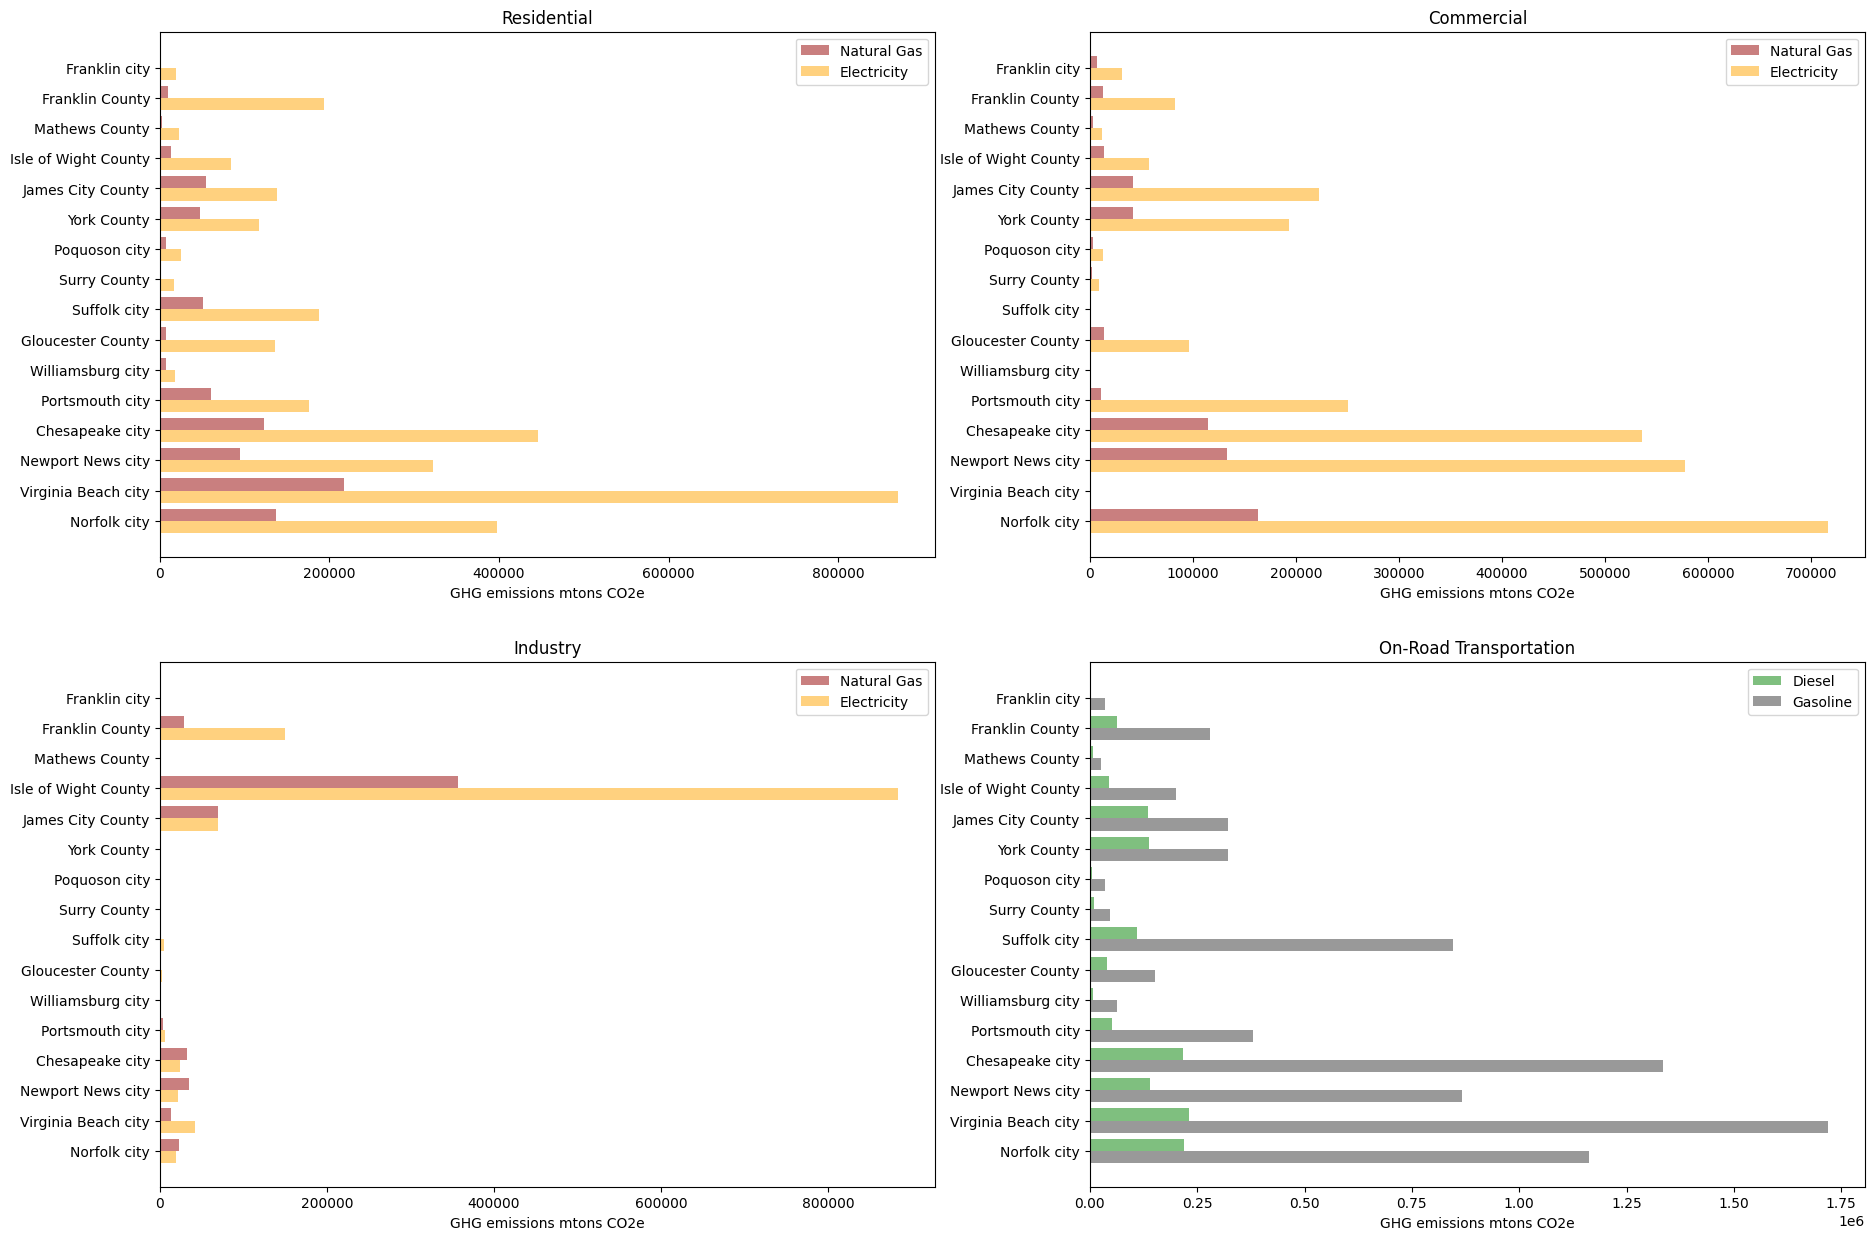

In [ ]:
# HRCE_res = 'Residential'
# HRCE_trans = 'On Road Transportation'
# HRCE_com = 'Commercial'
# HRCE_ind = 'Industry'

import matplotlib.pyplot as plt
import numpy as np

# plot charts for energy data (focused on GHG emissions bc all same units)

fig, ax = plt.subplots(2,2, figsize=(22,15))
bar_width = 0.4

# residential energy data
x = np.arange(len(HRCE_res['county_name']))
ax[0,0].barh(x + bar_width/2, HRCE_res['Natural Gas GHG emissions mtons CO2e'],  height=bar_width, color='brown', alpha=0.6, label='Natural Gas')
ax[0,0].barh(x - bar_width/2, HRCE_res['Electricity GHG emissions mtons CO2e'],  height=bar_width, color='orange', alpha=0.5, label='Electricity')
ax[0,0].set_yticks(x)
ax[0,0].set_yticklabels(HRCE_res['county_name'])
ax[0,0].set(xlabel='GHG emissions mtons CO2e', title='Residential')
ax[0,0].legend()

# commercial energy data
x = np.arange(len(HRCE_com['county_name']))
ax[0,1].barh(x + bar_width/2, HRCE_com['Natural Gas GHG emissions mtons CO2e'],  height=bar_width, color='brown', alpha=0.6, label='Natural Gas')
ax[0,1].barh(x - bar_width/2, HRCE_com['Electricity GHG emissions mtons CO2e'],  height=bar_width, color='orange', alpha=0.5, label='Electricity')
ax[0,1].set_yticks(x)
ax[0,1].set_yticklabels(HRCE_com['county_name'])
ax[0,1].set(xlabel='GHG emissions mtons CO2e', title='Commercial')
ax[0,1].legend()

# industry energy data
x = np.arange(len(HRCE_ind['county_name']))
ax[1,0].barh(x + bar_width/2, HRCE_ind['Natural Gas GHG emissions mtons CO2e'],  height=bar_width, color='brown', alpha=0.6, label='Natural Gas')
ax[1,0].barh(x - bar_width/2, HRCE_ind['Electricity GHG emissions mtons CO2e'],  height=bar_width, color='orange', alpha=0.5, label='Electricity')
ax[1,0].set_yticks(x)
ax[1,0].set_yticklabels(HRCE_ind['county_name'])
ax[1,0].set(xlabel='GHG emissions mtons CO2e', title='Industry')
ax[1,0].legend()

# on-road transportation energy data
x = np.arange(len(HRCE_trans['county_name']))
ax[1,1].barh(x + bar_width/2, HRCE_trans['Diesel GHG emissions mtons CO2e'],  height=bar_width, color='green', alpha=0.5, label='Diesel')
ax[1,1].barh(x - bar_width/2, HRCE_trans['Gasoline GHG emissions mtons CO2e'],  height=bar_width, color='black', alpha=0.4, label='Gasoline')
ax[1,1].set_yticks(x)
ax[1,1].set_yticklabels(HRCE_trans['county_name'])
ax[1,1].set(xlabel='GHG emissions mtons CO2e', title='On-Road Transportation')
ax[1,1].legend()

plt.show()

- Charts showing data on GHG emissions from natural gas and electricity consumption grouped by Hampton Roads counties
- Plus additional transportation consumption (most likely won't use for any additional analysis)

Chart Observations:
- Virginia Beach residential electricity consumption is more than half of Chesapeake or Norfolk
- Chesapeake, Newport News, and Norfolk electricity consumption highest for commercial infrastructure (no data for Virginia Beach, Williamsburg, and Suffolk)
- Isle of Wight industry energy consumption is way higher than any other county

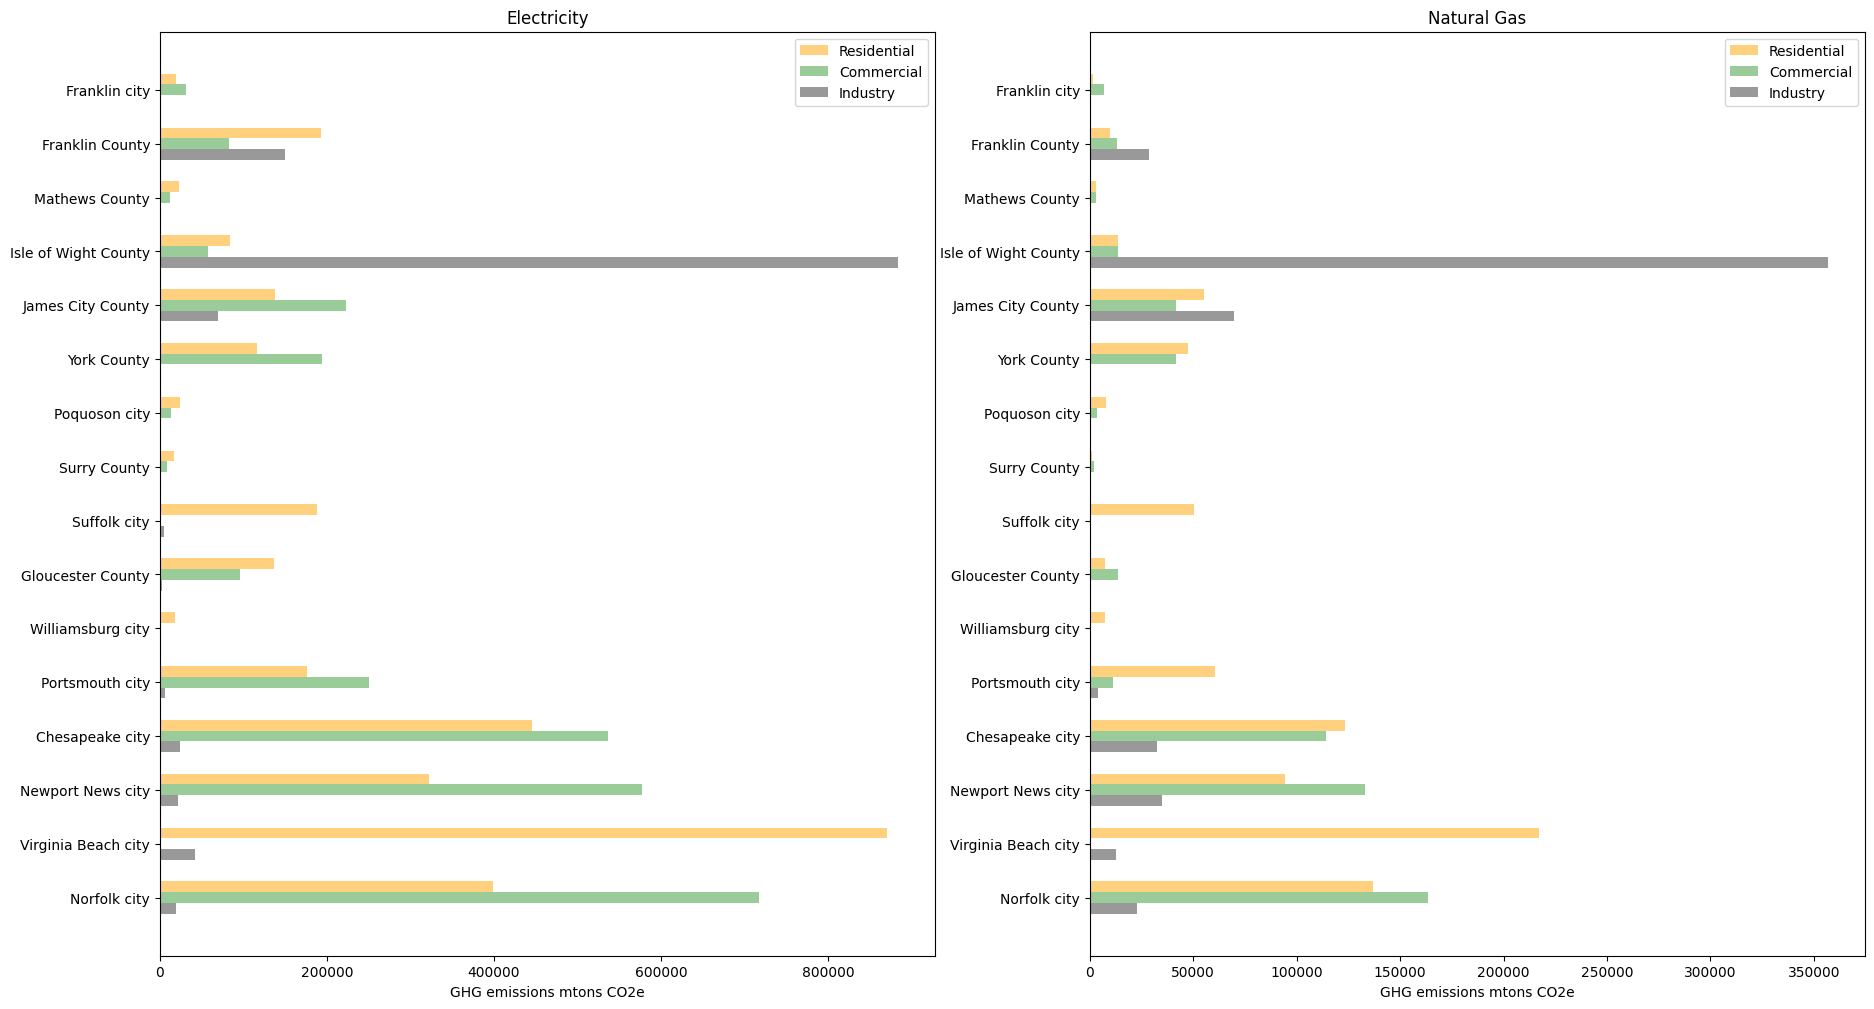

In [ ]:
# plot emissions from Residential, Commercial, and Industry

fig, ax = plt.subplots(1,2, figsize=(22,12))
bar_width = 0.2
x = np.arange(len(HRCE_res['county_name']))

# electricity emissions
ax[0].barh(x + bar_width, HRCE_res['Electricity GHG emissions mtons CO2e'], height=bar_width, color='orange', alpha=0.5, label='Residential')
ax[0].barh(x, HRCE_com['Electricity GHG emissions mtons CO2e'], height=bar_width, color='green', alpha=0.4, label='Commercial')
ax[0].barh(x - bar_width, HRCE_ind['Electricity GHG emissions mtons CO2e'], height=bar_width, color='black', alpha=0.4, label='Industry')
ax[0].set_yticks(x)
ax[0].set_yticklabels(HRCE_com['county_name'])
ax[0].set(xlabel='GHG emissions mtons CO2e', title='Electricity')
ax[0].legend()

# natural gas emissions
ax[1].barh(x + bar_width, HRCE_res['Natural Gas GHG emissions mtons CO2e'], height=bar_width, color='orange', alpha=0.5, label='Residential')
ax[1].barh(x, HRCE_com['Natural Gas GHG emissions mtons CO2e'], height=bar_width, color='green', alpha=0.4, label='Commercial')
ax[1].barh(x - bar_width, HRCE_ind['Natural Gas GHG emissions mtons CO2e'], height=bar_width, color='black', alpha=0.4, label='Industry')
ax[1].set_yticks(x)
ax[1].set_yticklabels(HRCE_com['county_name'])
ax[1].set(xlabel='GHG emissions mtons CO2e', title='Natural Gas')
ax[1].legend()

plt.show()

In [ ]:
# average emissions

np.mean(HRCE_res['Electricity GHG emissions mtons CO2e']) # 198180
np.mean(HRCE_com['Electricity GHG emissions mtons CO2e']) # 174833
np.mean(HRCE_ind['Electricity GHG emissions mtons CO2e']) # 76745

np.mean(HRCE_res['Natural Gas GHG emissions mtons CO2e']) # 52233
np.mean(HRCE_com['Natural Gas GHG emissions mtons CO2e']) # 35068
np.mean(HRCE_ind['Natural Gas GHG emissions mtons CO2e']) # 35204


35203.851946383125

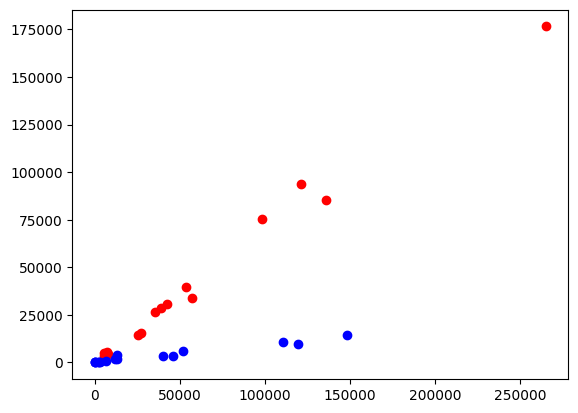

In [ ]:
# testing random data

# "Electricity expenditures ('000 $)"
# 'Electricity utility customers'

plt.scatter(HRCE_res["Electricity expenditures ('000 $)"], HRCE_res['Electricity utility customers'], color='red')
plt.scatter(HRCE_com["Local Electricity expenditures ('000 $)"], HRCE_com['Electricity utility customers'], color='blue')
#plt.scatter(HRCE_ind["Electricity expenditures ('000 $)"], color='green')

plt.show()